In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# K Means Cluster - DGI Embeddings 
Cluster the NAICS embeddings from the DGI embeddings (base features). Compare this clustering to the default NAICS code clusters on these embeddings

I select some cluster count (k) values to analyze in hierarchical embeddings

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
from pathlib import Path

In [5]:
import sklearn as sk
from sklearn.cluster import KMeans

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import importlib

In [8]:
from sba_gnn.sba_gnn import sg_plot, sg_embed

In [9]:
sg_plot.plot_defaults()

## Import Data

##### Embeddings

In [10]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('31_DATA_embeddings.parquet')) 

In [11]:
emb_feat = [c for c in embed_df.columns if c.startswith('emb_')]

##### NAICS info and map
Get one hot encoding length

In [12]:
naics_map = pd.read_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_map.parquet'))

In [13]:
one_hot_feat = naics_map[naics_map['NAICS_sector_sel'] == 1] \
    ['NAICS_sector'] \
    .drop_duplicates() \
    .to_list()
one_hot_feat_len = len(one_hot_feat) + 1
one_hot_feat_len

10

In [14]:
naics_info = pd.read_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_summary_stats.parquet')) 

##### NAICS group counts 
To select k for clustering for comparable levels to NAICS

In [15]:
naics_grp_stats = pd.read_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_grp_stats_all.csv'))

In [16]:
naics_grp_k = naics_grp_stats['count_grp'].drop_duplicates() \
    .sort_values().astype('int').to_list()
naics_grp_k

[20, 106, 354, 834]

## Get TSNE Values

In [17]:
tsne_df = pd.concat([sg_embed.emb_tsne_transform(embed_df[emb_feat]), embed_df['NAICS_orig']], axis=1)

## NAICS Sector "Clusters"
Get the silhouette score for the base naics

##### Merge NAICS info into embeddings

In [18]:
embed_df['NAICS_2'] = embed_df['NAICS_orig'].str[0:2]
embed_df = embed_df.drop(columns=['NAICS_sector', 'NAICS_sector_sel',
                                  'NAICS_sector_desc', 'NAICS_sector_comb', 'train_count'], 
                         errors='ignore') \
    .merge(naics_map[['NAICS_2', 'NAICS_sector', 'NAICS_sector_sel', 'NAICS_sector_desc', 'NAICS_sector_comb']], how='left') \
    .merge(naics_info.rename(columns={'NAICS':'NAICS_orig'})[['NAICS_orig', 'train_count']],
           on='NAICS_orig', how='left')

In [19]:
embed_df['NAICS_sector_filt'] = np.where(embed_df['NAICS_sector_sel'] == 0, 'Other',
                                         embed_df['NAICS_sector_comb'])
embed_df['NAICS_sector_filt'] = embed_df['NAICS_sector_filt'].astype('category')

In [20]:
embed_df['NAICS_sector_comb'] = embed_df['NAICS_sector_comb'].astype('category')

In [21]:
embed_train_df = embed_df[embed_df['train_count'] > 0]

In [22]:
tsne_df = tsne_df.drop(columns=['all_target_mean', 'menc_NAICS'], errors='ignore') \
    .merge(naics_info.rename(columns={'NAICS':'NAICS_orig'}) \
                                [['NAICS_orig', 'all_target_mean', 'menc_NAICS']],
                              how='left', on='NAICS_orig')

In [23]:
tsne_train_df = tsne_df[tsne_df['NAICS_orig'].isin(embed_train_df['NAICS_orig'])]

In [24]:
naics_silhouette = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_comb'])
naics_silhouette_values = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_comb'])

In [25]:
naics_silhouette

-0.1820822

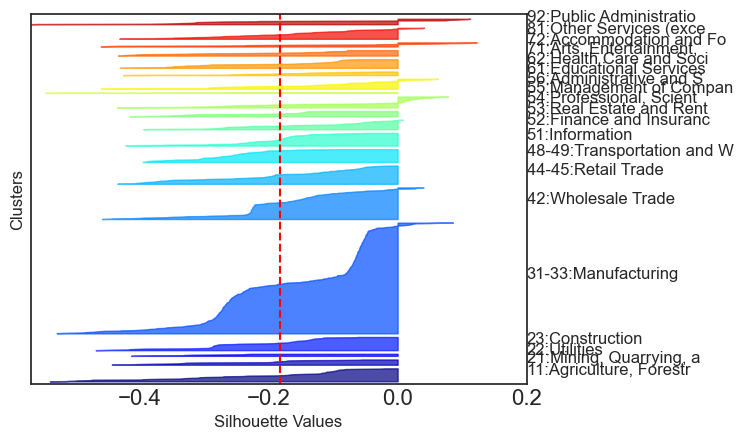

In [26]:
sg_embed.plot_silhouette(naics_silhouette_values, embed_df['NAICS_sector_comb'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_silhouette_base_naics_all.png'),
                 bbox_inches='tight') 

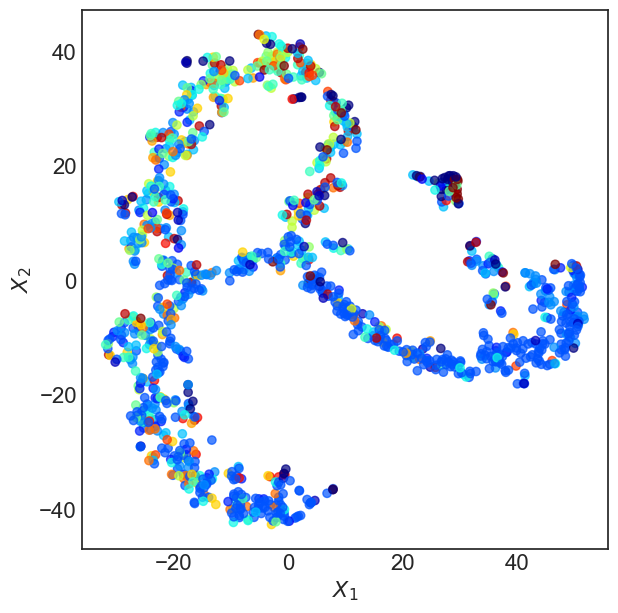

In [27]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector_comb'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_all.png'),
                 bbox_inches='tight') 

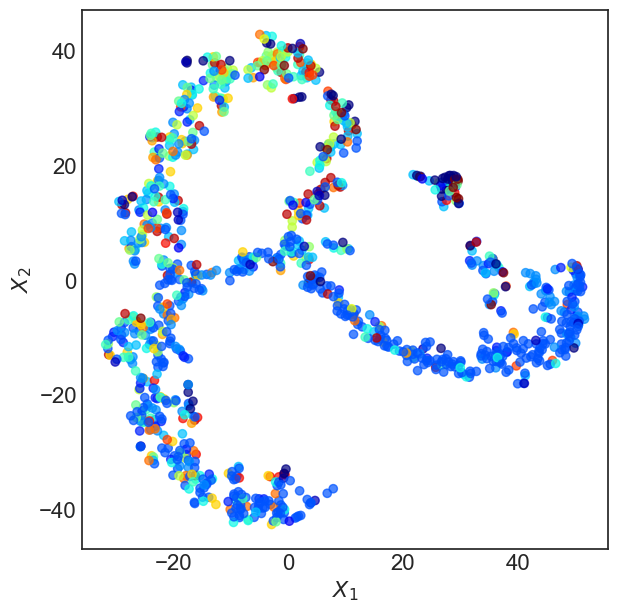

In [28]:
# Plot only on train data
sg_embed.plot_clusters(tsne_train_df, embed_train_df['NAICS_sector_comb'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_train.png'),
                 bbox_inches='tight') 

## NAICS Sectors - Used in One Hot Only
Get the silhouette scores for the NAICS groups used in the one hot encoder (top 8 levels plus "other")

In [29]:
naics_silhouette_sel = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_filt'])
naics_silhouette_values_sel = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_filt'])

In [30]:
naics_silhouette_sel

-0.14470285

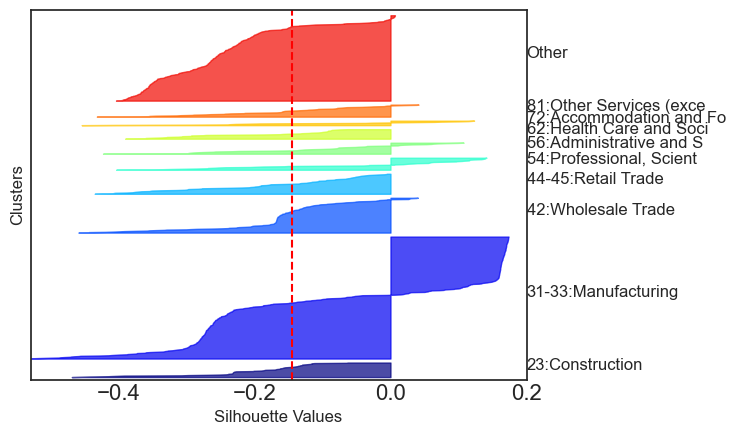

In [31]:
sg_embed.plot_silhouette(naics_silhouette_values_sel, embed_df['NAICS_sector_filt'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_silhouette_base_naics_sel.png'),
                 bbox_inches='tight') 

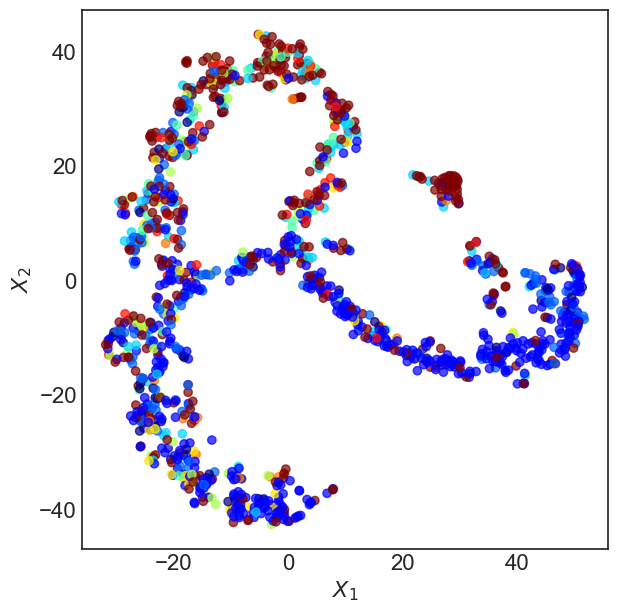

In [32]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector_filt'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_sel.png'),
                 bbox_inches='tight') 

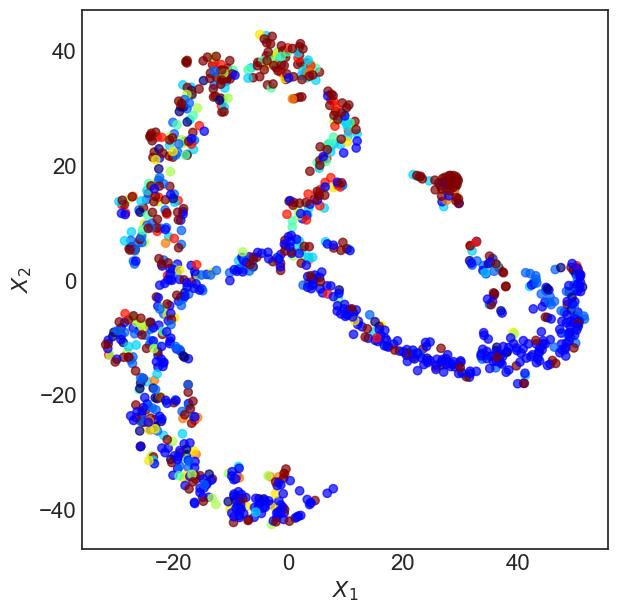

In [33]:
# Plot only on train data
sg_embed.plot_clusters(tsne_train_df, embed_train_df['NAICS_sector_filt'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_base_naics_sel_train.png'),
                 bbox_inches='tight') 

##### Save the silhouette scores

In [34]:
naics_silhouette_df = pd.DataFrame({'type':['all', 'sel'], 
                                    'score':[naics_silhouette, naics_silhouette_sel]})
naics_silhouette_df.to_csv(Path(setup.temp_path).joinpath('63_REPORT_naics_silhouette_mean.csv'))
naics_silhouette_df

,type,score
0,all,-0.182082
1,sel,-0.144703


## TSNE Plots By Target Rate

In [35]:
tsne_df.head()

,0,1,NAICS_orig,all_target_mean,menc_NAICS
0,3.592775,3.656248,722410,0.142825,0.141762
1,29.032541,-15.049530,332721,0.059633,0.064749
2,-0.455797,11.112865,445299,0.287306,0.204655
3,3.371012,11.442257,441120,0.240735,0.245455
4,9.814633,24.238195,512110,0.190087,0.204655


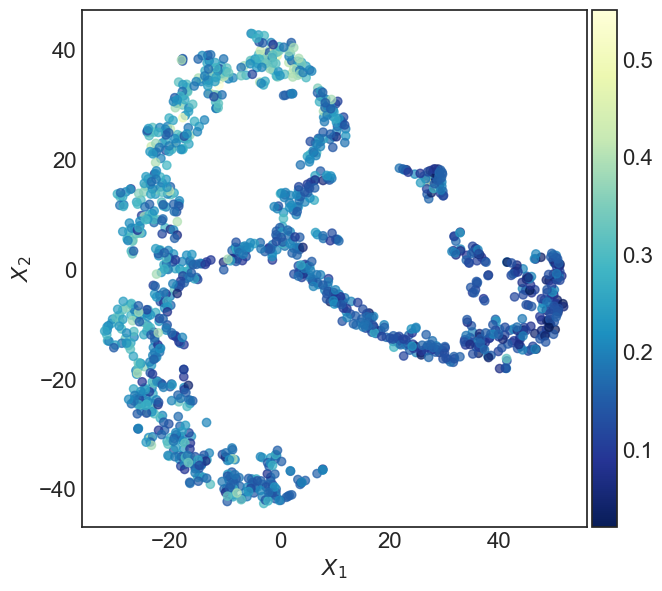

In [36]:
sg_embed.plot_clusters(tsne_df, tsne_df['menc_NAICS'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_menc.png'),
                bbox_inches='tight') 

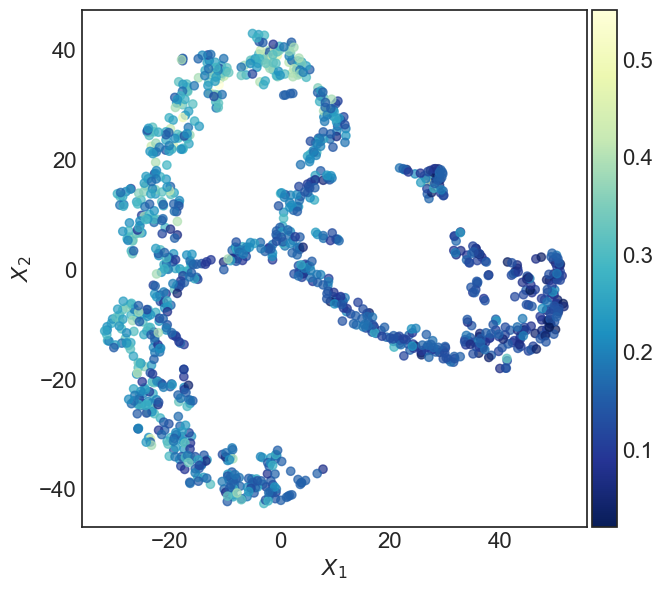

In [37]:
# train only
sg_embed.plot_clusters(tsne_train_df, tsne_train_df['menc_NAICS'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_menc_train.png'),
                bbox_inches='tight') 

In [38]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

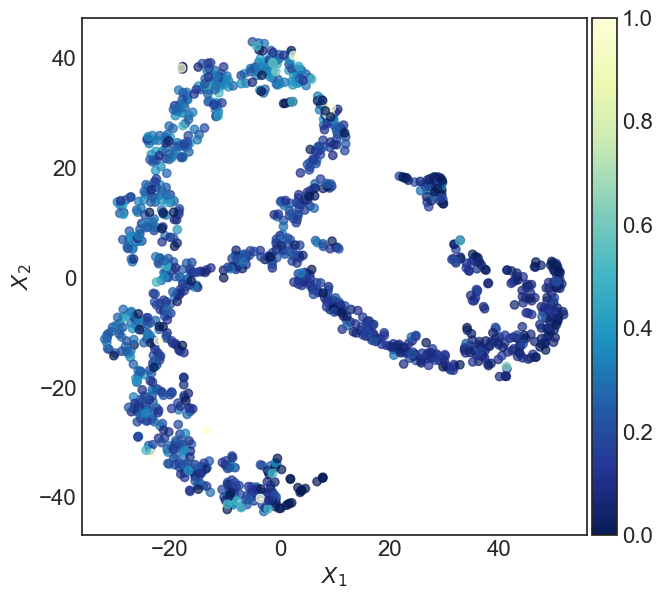

In [39]:
sg_embed.plot_clusters(tsne_df, tsne_df['all_target_mean'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), 
                       colorbar = True, aspect='equal')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_mean.png'),
                 bbox_inches='tight') 

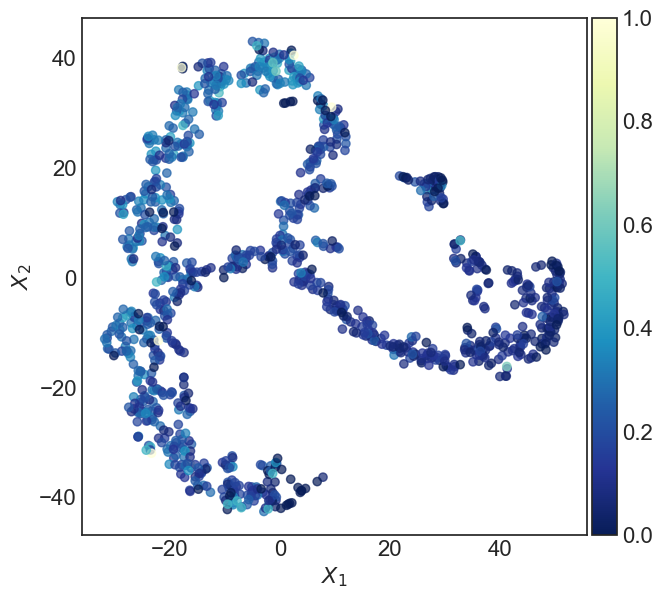

In [40]:
# Train only
sg_embed.plot_clusters(tsne_train_df, tsne_train_df['all_target_mean'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), 
                       colorbar = True, aspect='equal')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_tsne_naics_mean.png'),
                 bbox_inches='tight') 

## K Means Loop
Get silhouette scores and cluster info for a variety of counts.  Plot the best score, as well as the selected size.  We can use all data, as we have features for all 

Also add in a larger size (80) for hierarchical clustering later

In [41]:
# Low count range PLUS selected clusters
low_range = [n for n in np.arange(2, 25)]
mid_range = [n for n in np.arange(30, 200, 25)]
hi_range = [n for n in np.arange(200, 500, 50)]
range_n_clusters = sorted(list(set(low_range + mid_range + hi_range + naics_grp_k)))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 30, 55, 80, 105, 106, 130, 155, 180, 200, 250, 300, 350, 354, 400, 450, 834]


In [42]:
all_silhouette_summary = pd.DataFrame()
all_cluster_labels = pd.DataFrame()
all_cluster_centers = pd.DataFrame()
all_silhouette_values = pd.DataFrame()

for n_clusters in range_n_clusters:
    
    # Get the kmeans information
    cluster_labels, cluster_centers, silhouette_avg, sample_silhouette_values = \
        sg_embed.get_clusters_silhouettes(embed_df[emb_feat], n_clusters)
        
    # Save silhouette summary
    all_silhouette_summary = pd.concat([all_silhouette_summary, 
                                        pd.DataFrame({'n_clusters': [n_clusters],
                                                      'silhouette_avg':[silhouette_avg]})])
    
    # Save silhouette values
    sample_silhouette_df = pd.DataFrame(sample_silhouette_values, columns=['value'],
                                       index = embed_df.index)
    sample_silhouette_df['n_clusters'] = n_clusters
    sample_silhouette_df.set_index('n_clusters', append=True,  inplace=True)
    all_silhouette_values = pd.concat([all_silhouette_values, sample_silhouette_df])
    
    # Save cluster labels
    cluster_df = pd.DataFrame(cluster_labels, columns=['label'], index=embed_df.index)
    cluster_df['n_clusters'] = n_clusters
    cluster_df.set_index('n_clusters', append=True,  inplace=True)
    all_cluster_labels = pd.concat([all_cluster_labels, cluster_df])
    
    # Save cluster centers
    cluster_centers_df = pd.DataFrame(cluster_centers)
    cluster_centers_df['n_clusters'] = n_clusters
    cluster_centers_df.set_index('n_clusters', append=True, inplace=True)
    all_cluster_centers = pd.concat([all_cluster_centers, cluster_centers_df])

In [43]:
all_silhouette_values.reset_index(level=1, inplace=True)
all_cluster_labels.reset_index(level=1, inplace=True)
all_cluster_centers.reset_index(level=1, inplace=True)

In [44]:
all_silhouette_values.to_parquet(Path(setup.temp_path).joinpath('63_DATA_loop_silhouette_values.parquet'))
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('63_DATA_loop_silhouette_summary.csv'))

In [45]:
all_cluster_labels.to_parquet(Path(setup.temp_path).joinpath('63_DATA_loop_cluster_labels.parquet'))

In [46]:
all_cluster_centers.columns = [str(c) for c in all_cluster_centers.columns]
all_cluster_centers.to_parquet(Path(setup.temp_path).joinpath('63_DATA_loop_cluster_centers.parquet'))

##### Get the clusters with the best silhouette score

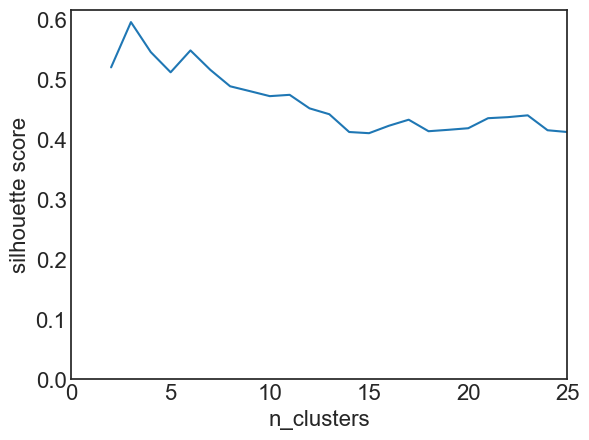

In [47]:
all_silhouette_summary.plot(x='n_clusters', y='silhouette_avg', legend=None)
plt.ylim(bottom=0)
plt.xlim([0,25])
plt.ylabel('silhouette score')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_summary.png'),
                 bbox_inches='tight') 
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('63_REPORT_loop_silhouette_summary.csv'))

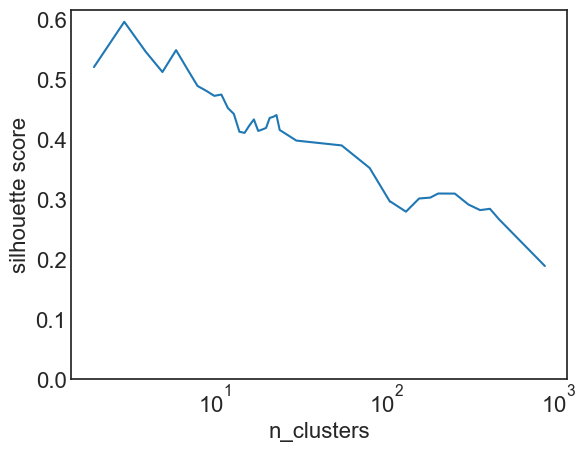

In [48]:
all_silhouette_summary.plot(x='n_clusters', y='silhouette_avg', legend=None)
plt.ylim(bottom=0)
#plt.xlim([0,25])
plt.gca().set_xscale('log')
plt.ylabel('silhouette score')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_summary2.png'),
                 bbox_inches='tight') 

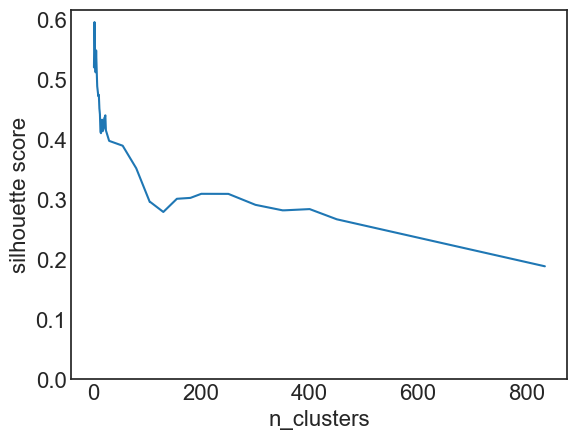

In [49]:
all_silhouette_summary.plot(x='n_clusters', y='silhouette_avg', legend=None)
plt.ylim(bottom=0)
#plt.xlim([0,25])
#plt.gca().set_xscale('log')
plt.ylabel('silhouette score')
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_summary3.png'),
                 bbox_inches='tight') 

In [50]:
best_clus = all_silhouette_summary.sort_values('silhouette_avg', ascending=False)['n_clusters'].iloc[0]
best_clus

3

## Plots for Best Score Clusters

In [51]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [52]:
best_values = all_silhouette_values[all_silhouette_values['n_clusters'] == best_clus] \
    .drop(columns='n_clusters')
best_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == best_clus] \
     .drop(columns='n_clusters')  

In [53]:
np.mean(best_values.to_numpy())

0.5957756

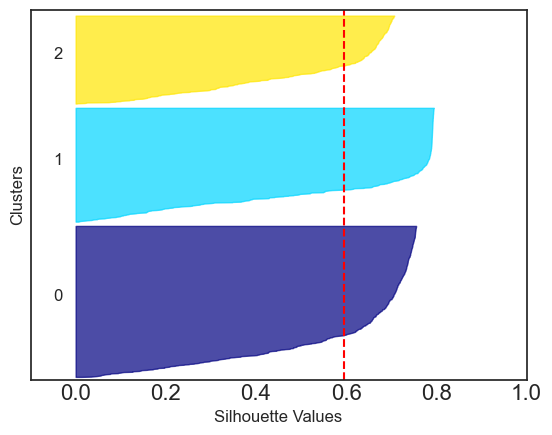

In [54]:
sg_embed.plot_silhouette(best_values.to_numpy(), best_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_best.png'),
                 bbox_inches='tight') 

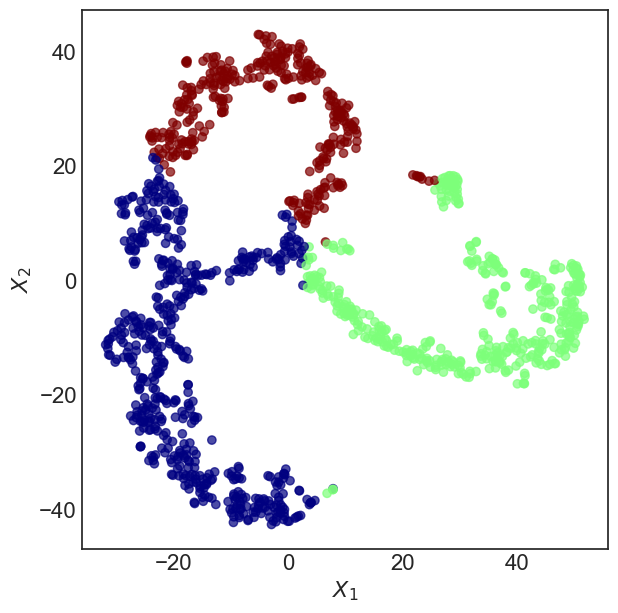

In [55]:
sg_embed.plot_clusters(tsne_df, best_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_clusters_best.png'),
                 bbox_inches='tight') 

## Plots for NAICS sector match length
Use the same number of levels as we have from the original one hot encoding

In [56]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [57]:
sel_values = all_silhouette_values[all_silhouette_values['n_clusters'] == one_hot_feat_len] \
    .drop(columns='n_clusters')
sel_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == one_hot_feat_len] \
     .drop(columns='n_clusters')  

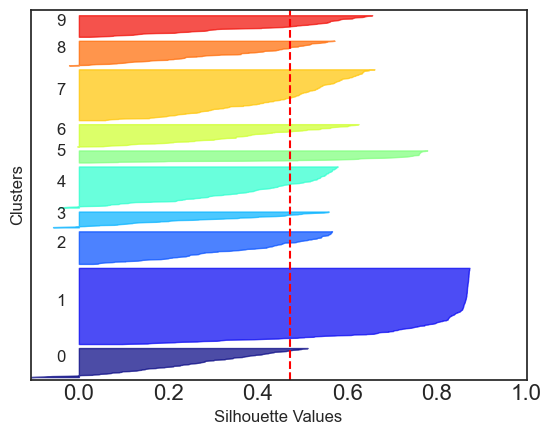

In [58]:
sg_embed.plot_silhouette(sel_values.to_numpy(), sel_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_selected.png'),
                 bbox_inches='tight') 

In [59]:
np.mean(sel_values.to_numpy())

0.47234097

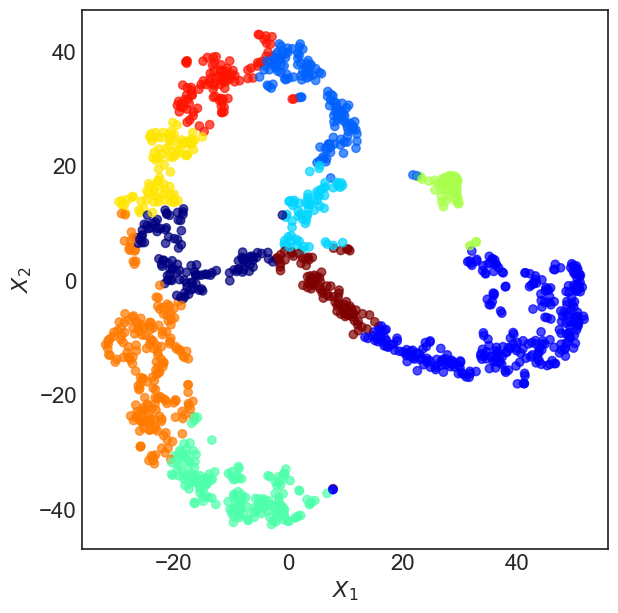

In [60]:
sg_embed.plot_clusters(tsne_df, sel_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_clusters_selected.png'),
                 bbox_inches='tight') 

## Save the embeddings with TSNE and Cluster Info
Include one hot encodings, selected k (for hierarchical encodings)

#### Get embeddings, TSNE, and NAICS sector count selected clusters

In [61]:
embed_fin_1 = pd.concat([embed_df.drop(columns=['tsne_0', 'tsne_1', 'NAICS_orig', 'cluster'], errors='ignore'),
                          tsne_df.rename(columns={0:'tsne_0', 1:'tsne_1'}),
                          sel_labels.rename(columns={'label':'cluster'})], axis=1)

In [73]:
save_grp = sorted(list(set(naics_grp_k + [one_hot_feat_len, best_clus])))
save_grp

[3, 10, 20, 106, 354, 834]

##### Append selected k for range to test in hierarchical blend

In [74]:
embed_fin_2 = pd.concat([all_cluster_labels[all_cluster_labels['n_clusters'] == n] \
                         .drop(columns='n_clusters') for n in save_grp], axis=1,
                        keys = [f'cluster_{n:03d}' for n in save_grp])
embed_fin_2.columns = embed_fin_2.columns.get_level_values(0)

In [75]:
embed_fin = pd.concat([embed_fin_1, embed_fin_2], axis=1)

In [76]:
embed_fin.filter(like='cluster').head(5)

,cluster,cluster_003,cluster_010,cluster_020,cluster_106,cluster_354,cluster_834
0,9,1,9,17,77,29,169
1,1,1,1,13,85,348,593
2,3,0,3,3,40,304,331
3,3,2,3,3,4,258,374
4,2,2,2,14,66,202,275


In [77]:
embed_fin.filter(like='NAICS').head(2)

,NAICS_2,NAICS_sector,NAICS_sector_sel,NAICS_sector_desc,NAICS_sector_comb,NAICS_sector_filt,NAICS_orig,menc_NAICS
0,72,72,1,Accommodation and Food Services,72:Accommodation and Fo,72:Accommodation and Fo,722410,0.141762
1,33,31-33,1,Manufacturing,31-33:Manufacturing,31-33:Manufacturing,332721,0.064749


In [78]:
embed_fin_df = pd.concat([embed_fin, 
                           pd.get_dummies(embed_fin['cluster'],prefix='NC_', dtype='int')],
                         axis=1)

In [79]:
embed_fin_df.head(2)

,source,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,NAICS_2,...,NC__0,NC__1,NC__2,NC__3,NC__4,NC__5,NC__6,NC__7,NC__8,NC__9
0,n_722410,0.282619,0.329673,-0.001372,0.410912,0.502174,0.281283,-0.390174,0.398818,72,...,0,0,0,0,0,0,0,0,0,1
1,n_332721,0.258869,0.301969,-0.001257,0.376381,0.453659,-0.381201,-0.360459,0.468067,33,...,0,1,0,0,0,0,0,0,0,0


In [80]:
embed_fin_df.to_parquet(Path(setup.temp_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

## Combined Plot

In [69]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

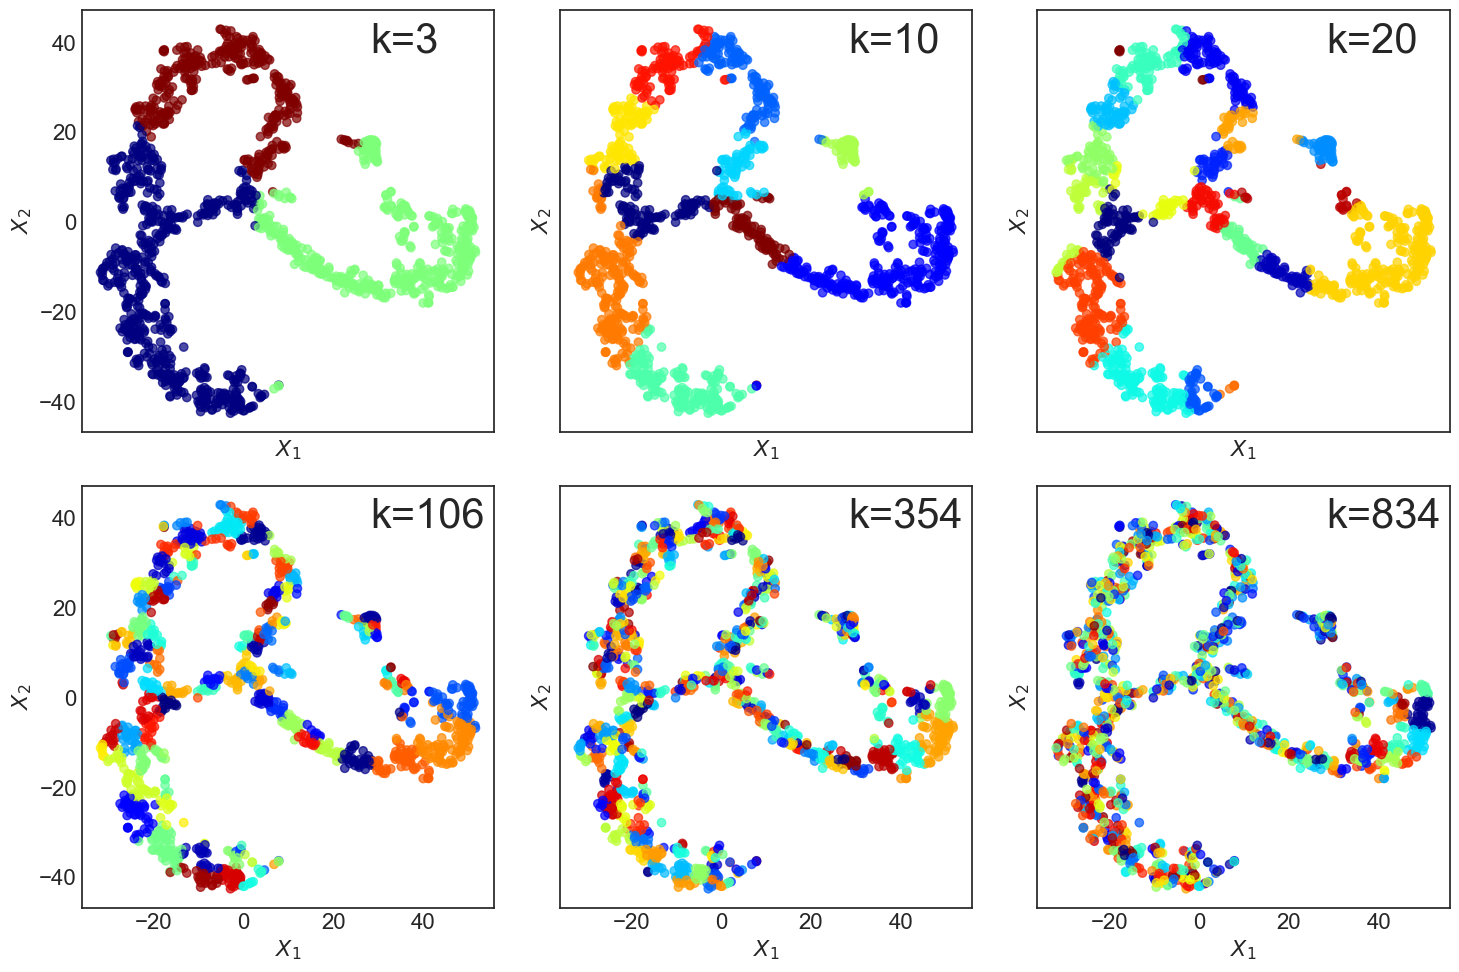

In [70]:
fig, ax = plt.subplots(int(np.ceil(len(save_grp)/3)), 3, sharex=True, sharey=True,
                      figsize=(15,10))
for i in range(len(save_grp)):
    col = int(i % 3)
    row = int(np.floor(i / 3))
    this_values = all_silhouette_values[all_silhouette_values['n_clusters'] == save_grp[i]] \
        .drop(columns='n_clusters')
    this_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == save_grp[i]] \
        .drop(columns='n_clusters')  
    
    sg_embed.plot_clusters(tsne_df, this_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'), ax=ax[row, col])
    
    ax[row, col].annotate(f'k={save_grp[i]}', xy=(0.7, 0.9), xycoords="axes fraction",
                         fontsize=30)
    #plt.gcf().savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_selected.png'),
    #             bbox_inches='tight') 
fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('63_PLOT_loop_silhouette_sel_ary.png'),
               bbox_inches='tight')
plt.show()